# Quantitative analysis of the proposed skill metrics: Skill Alignment and Skill Length Distrubtion

In [1]:
import itertools
import json

import matplotlib
import matplotlib.pyplot as plt
import pyalign
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from scipy.stats import poisson
import joblib

from temporal_explanations_4_drl.dataset import (
    load_trajectories,
    load_discrete_actions,
)
from temporal_explanations_4_drl.plan import Plan
from temporal_explanations_4_drl.skill import skill_labels_to_trajectory_skills, discrete_policy_distance, \
    SkillInstance

In [2]:
dataset_folder = "../datasets/rainbow-Breakout"

In [3]:
# Hand-labelled
with open(f"{dataset_folder}/hand-labelled-skills.json") as file:
    data = json.load(file)


num_trajectories = len(data["skill_labels"])
skill_labels = [labels for labels in data["skill_labels"].values()]
actions = load_discrete_actions(
    f"{dataset_folder}/trajectories", num_files=num_trajectories
)
trajectories = load_trajectories(f"{dataset_folder}/trajectories")[:num_trajectories]
assert len(skill_labels) == len(trajectories)
assert all(len(labels) == traj.length for labels, traj in zip(skill_labels, trajectories))
skill_labels = np.concatenate(skill_labels)

skills = skill_labels_to_trajectory_skills(skill_labels, actions, trajectories)
hand_labelled_plan = Plan(skills)

In [4]:
# Zahavy
with np.load(f'{dataset_folder}/kmeans-st-state-value/summary.npz', allow_pickle=True) as file:
    optimal_model = file["optimal_model"].item()
    optimal_model.pop("index")

model_name = "-".join(f"{key}-{value}" for key, value in optimal_model.items())
print(model_name)
model_data = joblib.load(f'{dataset_folder}/kmeans-st-state-value/{model_name}.joblib')

skill_labels = model_data["skill_labels"][:trajectories[-1].end]
skill_labels[np.where(skill_labels == 4)] = 3  # ignore
skills = skill_labels_to_trajectory_skills(skill_labels, actions, trajectories)
zahavy_plan = Plan(skills)

n_clusters-5-window_size-0


## Plan visualisation - Hand-labelled and Zahavy et al., 2016

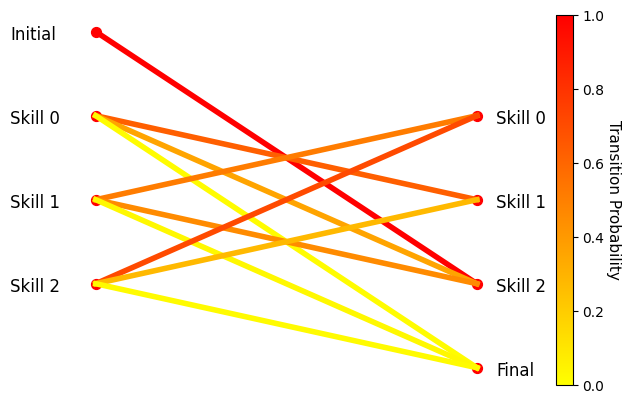

In [5]:
# print(plan.transition_probability)
fig, ax = plt.subplots()
ax.axis("off")

# Draw the nodes
current_skill_nodes = ax.scatter(
    np.full(hand_labelled_plan.unique_skill_types + 1, 1),
    np.arange(1, hand_labelled_plan.unique_skill_types + 2),
    color="red", s=50,
)
next_skill_nodes = ax.scatter(
    np.full(hand_labelled_plan.unique_skill_types + 1, 1.2),
    np.arange(hand_labelled_plan.unique_skill_types + 1),
    color="red", s=50,
)
for i in range(hand_labelled_plan.unique_skill_types):
    ax.text(
        0.955,
        hand_labelled_plan.unique_skill_types - i - 0.09,
        f"Skill {i}",
        color="black",
        fontsize=12,
    )
    ax.text(
        1.21,
        hand_labelled_plan.unique_skill_types - i - 0.09,
        f"Skill {i}",
        color="black",
        fontsize=12,
    )

ax.text(0.955, hand_labelled_plan.unique_skill_types + 1 - 0.09, "Initial", color="black", fontsize=12)
ax.text(1.21, -0.09, "Final", color="black", fontsize=12)

# Draw the transition edges
cmap = plt.cm.autumn_r
norm = matplotlib.colors.Normalize(0, 1)
for i in range(-1, hand_labelled_plan.unique_skill_types):
    for j in range(hand_labelled_plan.unique_skill_types + 1):
        if 0 < hand_labelled_plan.transition_probability[i, j]:
            ax.plot(
                [1, 1.2],
                [hand_labelled_plan.unique_skill_types - i, hand_labelled_plan.unique_skill_types - j],
                color=cmap(norm(hand_labelled_plan.transition_probability[i, j])),
                linewidth=4,
            )

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.6)
cbar = fig.colorbar(sm, cax=cax)
cax.set_ylabel("Transition Probability", rotation=270, labelpad=12, fontsize=11)

# cb.ax.set_yticks(np.linspace(0, 1, 6), label=["0%", "20%", "40%", "60%", "80%", "100%"])
# cb.set_label("Skill Transition Probability", rotation=270)

plt.savefig("figs/quantitative/plan-hand-labelled-Breakout.pdf")
plt.savefig("figs/quantitative/plan-hand-labelled-Breakout.png")

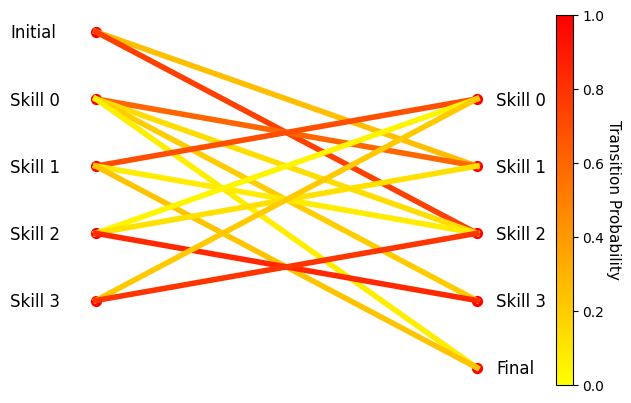

In [6]:
# print(plan.transition_probability)
fig, ax = plt.subplots()
ax.axis("off")

# Draw the nodes
current_skill_nodes = ax.scatter(
    np.full(zahavy_plan.unique_skill_types + 1, 1),
    np.arange(1, zahavy_plan.unique_skill_types + 2),
    color="red", s=50,
)
next_skill_nodes = ax.scatter(
    np.full(zahavy_plan.unique_skill_types + 1, 1.2),
    np.arange(zahavy_plan.unique_skill_types + 1),
    color="red", s=50,
)
for i in range(zahavy_plan.unique_skill_types):
    ax.text(
        0.955,
        zahavy_plan.unique_skill_types - i - 0.09,
        f"Skill {i}",
        color="black",
        fontsize=12,
    )
    ax.text(
        1.21,
        zahavy_plan.unique_skill_types - i - 0.09,
        f"Skill {i}",
        color="black",
        fontsize=12,
    )

ax.text(0.955, zahavy_plan.unique_skill_types + 1 - 0.09, "Initial", color="black", fontsize=12)
ax.text(1.21, -0.09, "Final", color="black", fontsize=12)

# Draw the transition edges
cmap = plt.cm.autumn_r
norm = matplotlib.colors.Normalize(0, 1)
for i in range(-1, zahavy_plan.unique_skill_types):
    for j in range(zahavy_plan.unique_skill_types + 1):
        if 0 < zahavy_plan.transition_probability[i, j]:
            ax.plot(
                [1, 1.2],
                [zahavy_plan.unique_skill_types - i, zahavy_plan.unique_skill_types - j],
                color=cmap(norm(zahavy_plan.transition_probability[i, j])),
                linewidth=4,
            )

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.6)
cbar = fig.colorbar(sm, cax=cax)
cax.set_ylabel("Transition Probability", rotation=270, labelpad=12, fontsize=11)

# cb.ax.set_yticks(np.linspace(0, 1, 6), label=["0%", "20%", "40%", "60%", "80%", "100%"])
# cb.set_label("Skill Transition Probability", rotation=270)

plt.savefig("figs/quantitative/plan-zahavy-Breakout.pdf")
plt.savefig("figs/quantitative/plan-zahavy-Breakout.png")

## Skill length distribution - Hand labelled and Zahavy et al., 2016

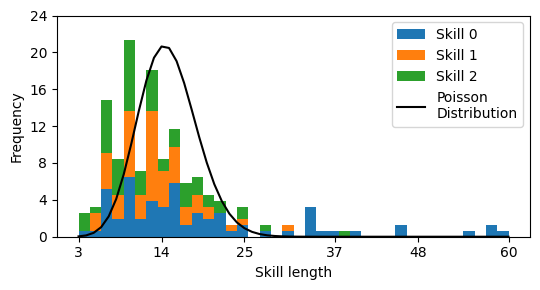

In [7]:
_, ax = plt.subplots(figsize=(5.5, 3))

skill_lengths = [np.concatenate(skill_lengths).astype(np.int32)
                 for skill_lengths in hand_labelled_plan.transition_lengths[:-1]]
concat_skill_lengths = np.concatenate(skill_lengths)
uniques = np.unique(concat_skill_lengths)
lam = np.mean(concat_skill_lengths)

hand_labelled_plan_labels = [f"Skill {j}" for j in range(hand_labelled_plan.unique_skill_types)]
hand_labelled_colours = list(matplotlib.colors.TABLEAU_COLORS.keys())[:hand_labelled_plan.unique_skill_types]

ax.hist(
    skill_lengths, bins=len(uniques),
    stacked=True, fill=True, density=True,
    label=hand_labelled_plan_labels, color=hand_labelled_colours
)
ax.plot(np.arange(min(uniques), max(uniques) + 1),
        poisson.pmf(np.arange(min(uniques), max(uniques) + 1), lam),
        c="black", label="Poisson\nDistribution")

# ax.plot(np.linspace(min(lengths), max(lengths), 200), poisson.ppf(np.linspace(min(lengths), max(lengths), 200), mu=lam))
ax.set_xticks(np.linspace(min(uniques), max(uniques), 6, dtype=int))
ticks = ax.get_yticks()
ax.set_yticks(ticks, labels=(len(concat_skill_lengths) * ticks).astype(int))
ax.set_xlabel("Skill length")
ax.set_ylabel("Frequency")
ax.legend()

plt.tight_layout()
plt.savefig("figs/quantitative/skill-length-distribution-hand-Breakout.pdf")
plt.savefig("figs/quantitative/skill-length-distribution-hand-Breakout.png")

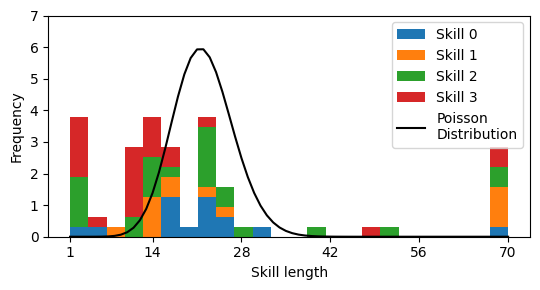

In [8]:
_, ax = plt.subplots(figsize=(5.5, 3))

skill_lengths = [
    np.array([length if length < 70 else 70
              for length in np.concatenate(skill_lengths).astype(np.int32)])
    for skill_lengths in zahavy_plan.transition_lengths[:-1]
]
# skill_lengths = [np.concatenate(skill_lengths).astype(np.int32)
#                  for skill_lengths in zahavy_plan.transition_lengths]
concat_skill_lengths = np.concatenate(skill_lengths)
uniques = np.unique(concat_skill_lengths)
lam = np.mean(concat_skill_lengths)

zahavy_labels = [f"Skill {j}" for j in range(zahavy_plan.unique_skill_types)]
zahavy_colours = list(matplotlib.colors.TABLEAU_COLORS.keys())[:zahavy_plan.unique_skill_types]

ax.hist(
    skill_lengths, bins=len(uniques),
    stacked=True, fill=True, density=True,
    label=zahavy_labels, color=zahavy_colours
)
ax.plot(np.arange(min(uniques), max(uniques) + 1),
        poisson.pmf(np.arange(min(uniques), max(uniques) + 1), lam),
        c="black", label="Poisson\nDistribution")

ax.set_xticks(np.linspace(min(uniques), max(uniques), 6, dtype=int))
ticks = ax.get_yticks()
ticks = np.linspace(ticks[0], ticks[-1], 8)
ax.set_yticks(ticks, labels=(len(concat_skill_lengths) * ticks).astype(int))
ax.set_xlabel("Skill length")
ax.set_ylabel("Frequency")
ax.legend()

plt.tight_layout()
plt.savefig("figs/quantitative/skill-length-distribution-zahavy-Breakout.pdf")
plt.savefig("figs/quantitative/skill-length-distribution-zahavy-Breakout.png")

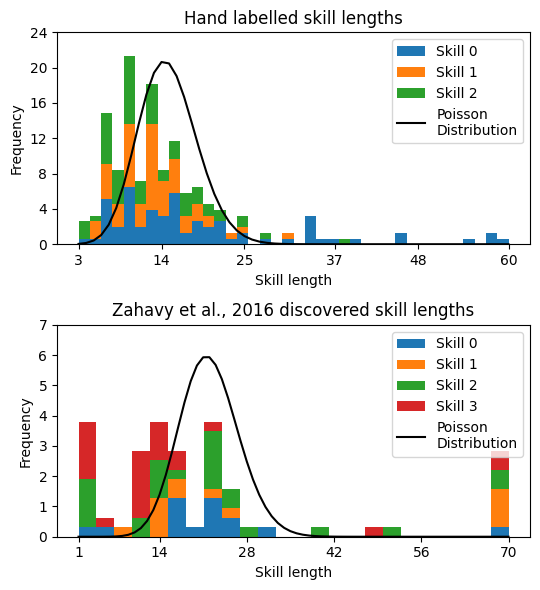

In [18]:
_, axs = plt.subplots(nrows=2, figsize=(5.5, 6))

skill_lengths = [np.concatenate(skill_lengths).astype(np.int32)
                 for skill_lengths in hand_labelled_plan.transition_lengths[:-1]]
concat_skill_lengths = np.concatenate(skill_lengths)
uniques = np.unique(concat_skill_lengths)
lam = np.mean(concat_skill_lengths)

hand_labelled_plan_labels = [f"Skill {j}" for j in range(hand_labelled_plan.unique_skill_types)]
hand_labelled_colours = list(matplotlib.colors.TABLEAU_COLORS.keys())[:hand_labelled_plan.unique_skill_types]

axs[0].set_title("Hand labelled skill lengths")
axs[0].hist(
    skill_lengths, bins=len(uniques),
    stacked=True, fill=True, density=True,
    label=hand_labelled_plan_labels, color=hand_labelled_colours
)
axs[0].plot(np.arange(min(uniques), max(uniques) + 1),
        poisson.pmf(np.arange(min(uniques), max(uniques) + 1), lam),
        c="black", label="Poisson\nDistribution")

# ax.plot(np.linspace(min(lengths), max(lengths), 200), poisson.ppf(np.linspace(min(lengths), max(lengths), 200), mu=lam))
axs[0].set_xticks(np.linspace(min(uniques), max(uniques), 6, dtype=int))
ticks = axs[0].get_yticks()
axs[0].set_yticks(ticks, labels=(len(concat_skill_lengths) * ticks).astype(int))
axs[0].set_xlabel("Skill length")
axs[0].set_ylabel("Frequency")
axs[0].legend()

skill_lengths = [
    np.array([length if length < 70 else 70
              for length in np.concatenate(skill_lengths).astype(np.int32)])
    for skill_lengths in zahavy_plan.transition_lengths[:-1]
]
# skill_lengths = [np.concatenate(skill_lengths).astype(np.int32)
#                  for skill_lengths in zahavy_plan.transition_lengths]
concat_skill_lengths = np.concatenate(skill_lengths)
uniques = np.unique(concat_skill_lengths)
lam = np.mean(concat_skill_lengths)

zahavy_labels = [f"Skill {j}" for j in range(zahavy_plan.unique_skill_types)]
zahavy_colours = list(matplotlib.colors.TABLEAU_COLORS.keys())[:zahavy_plan.unique_skill_types]

axs[1].set_title("Zahavy et al., 2016 discovered skill lengths")
axs[1].hist(
    skill_lengths, bins=len(uniques),
    stacked=True, fill=True, density=True,
    label=zahavy_labels, color=zahavy_colours
)
axs[1].plot(np.arange(min(uniques), max(uniques) + 1),
        poisson.pmf(np.arange(min(uniques), max(uniques) + 1), lam),
        c="black", label="Poisson\nDistribution")

axs[1].set_xticks(np.linspace(min(uniques), max(uniques), 6, dtype=int))
ticks = axs[1].get_yticks()
ticks = np.linspace(ticks[0], ticks[-1], 8)
axs[1].set_yticks(ticks, labels=(len(concat_skill_lengths) * ticks).astype(int))
axs[1].set_xlabel("Skill length")
axs[1].set_ylabel("Frequency")
axs[1].legend()

plt.tight_layout()
plt.savefig("figs/quantitative/skill-length-distribution-hand-zahavy-Breakout.pdf")
plt.savefig("figs/quantitative/skill-length-distribution-hand-zahavy-Breakout.png")

## Skill Alignment - Hand labelled and Zahavy et al., 2016

In [10]:
pf = pyalign.problems.general(discrete_policy_distance)
solver = pyalign.solve.LocalSolver(
    gap_cost=pyalign.gaps.LinearGapCost(1), codomain=pyalign.solve.Solution
)

def normalised_alignment_metric(skill_1: SkillInstance, skill_2: SkillInstance):
    problem = pf.new_problem(skill_1.actions, skill_2.actions)
    solution: pyalign.solve.Solution = solver.solve(problem)

    return np.max(solution.score) / min(skill_1.length, skill_2.length)


print('hand labelled')
hand_labelled_alignment = np.zeros(shape=(hand_labelled_plan.unique_skill_types, hand_labelled_plan.unique_skill_types))
for i, j in itertools.combinations_with_replacement(range(hand_labelled_plan.unique_skill_types), 2):
    print(f'i={i}, j={j}, i len={len(hand_labelled_plan.skill_instances[i])}, j len={len(hand_labelled_plan.skill_instances[j])}')
    skill_pairs = zip(np.random.choice(hand_labelled_plan.skill_instances[i], size=100),
                      np.random.choice(hand_labelled_plan.skill_instances[j], size=100))

    alignment = np.mean([
        normalised_alignment_metric(skill_i, skill_j)
        for skill_i, skill_j in skill_pairs
    ])
    hand_labelled_alignment[i, j] = hand_labelled_alignment[j, i] = alignment

print('zahavy alignment')
zahavy_alignment = np.zeros(shape=(zahavy_plan.unique_skill_types, zahavy_plan.unique_skill_types))
for i, j in itertools.combinations_with_replacement(range(zahavy_plan.unique_skill_types), 2):
    skills_i = [skill for skill in zahavy_plan.skill_instances[i] if skill.length > 2]
    skills_j = [skill for skill in zahavy_plan.skill_instances[j] if skill.length > 2]

    print(f'i={i}, j={j}, i len={len(zahavy_plan.skill_instances[i])}, j len={len(zahavy_plan.skill_instances[j])}')
    skill_pairs = zip(np.random.choice(skills_i, size=200),
                      np.random.choice(skills_j, size=200))
    alignment = np.mean([
        normalised_alignment_metric(skill_i, skill_j)
        for skill_i, skill_j in skill_pairs
    ])
    zahavy_alignment[i, j] = zahavy_alignment[j, i] = alignment

hand labelled
i=0, j=0, i len=78, j len=78
i=0, j=1, i len=78, j len=66
i=0, j=2, i len=78, j len=62
i=1, j=1, i len=66, j len=66
i=1, j=2, i len=66, j len=62
i=2, j=2, i len=62, j len=62
zahavy alignment
i=0, j=0, i len=15, j len=15
i=0, j=1, i len=15, j len=13
i=0, j=2, i len=15, j len=25
i=0, j=3, i len=15, j len=24
i=1, j=1, i len=13, j len=13
i=1, j=2, i len=13, j len=25
i=1, j=3, i len=13, j len=24
i=2, j=2, i len=25, j len=25
i=2, j=3, i len=25, j len=24
i=3, j=3, i len=24, j len=24


In [11]:
print(f'Zahavy et al., 2016 -> intra skill alignment={np.mean(zahavy_alignment[np.where(np.eye(4))]):.4f}, inter skill alignment={np.mean(zahavy_alignment[np.where(np.eye(4) == 0)]):.4f}')
print(f'Hand-labelled -> intra skill alignment={np.mean(hand_labelled_alignment[np.where(np.eye(3))]):.4f}, inter skill alignment={np.mean(hand_labelled_alignment[np.where(np.eye(3) == 0)]):.4f}')

Zahavy et al., 2016 -> intra skill alignment=0.6046, inter skill alignment=0.5304
Hand-labelled -> intra skill alignment=0.5357, inter skill alignment=0.3939


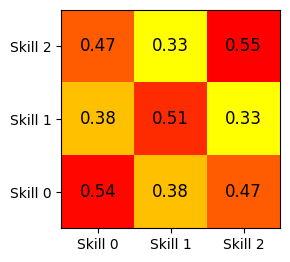

In [12]:
_, ax = plt.subplots(figsize=(3, 3.3))
ax.imshow(hand_labelled_alignment, cmap='autumn_r', origin="lower")
ax.set_yticks(
    np.arange(hand_labelled_plan.unique_skill_types),
    labels=[f"Skill {i}" for i in range(hand_labelled_plan.unique_skill_types)],
)
ax.set_xticks(
    np.arange(hand_labelled_plan.unique_skill_types),
    labels=[f"Skill {i}" for i in range(hand_labelled_plan.unique_skill_types)],
)
# for i in range(0, hand_labelled_plan.unique_skill_types - 1):
#     axs[0].axhline(i + 0.5, color="black")
#     axs[0].axvline(i + 0.5, color="black")

for i, j in np.ndindex(hand_labelled_alignment.shape):
    ax.text(j, i, f'{hand_labelled_alignment[i, j]:.2f}', ha="center", va="center", color="black", fontsize=12)

plt.tight_layout()
plt.savefig("figs/quantitative/skill-alignment-hand-Breakout.pdf")
plt.savefig("figs/quantitative/skill-alignment-hand-Breakout.png")

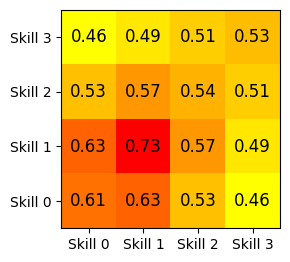

In [13]:
_, ax = plt.subplots(figsize=(3, 3.3))

ax.imshow(zahavy_alignment, cmap="autumn_r", origin="lower")
ax.set_yticks(
    np.arange(zahavy_plan.unique_skill_types),
    labels=[f"Skill {i}" for i in range(zahavy_plan.unique_skill_types)],
)
ax.set_xticks(
    np.arange(zahavy_plan.unique_skill_types),
    labels=[f"Skill {i}" for i in range(zahavy_plan.unique_skill_types)],
)
# for i in range(0, zahavy_plan.unique_skill_types - 1):
#     axs[1].axhline(i + 0.5, color="black")
#     axs[1].axvline(i + 0.5, color="black")

for i, j in np.ndindex(zahavy_alignment.shape):
    ax.text(j, i, f'{zahavy_alignment[i, j]:.2f}', ha="center", va="center", color="black", fontsize=12)

plt.tight_layout()
plt.savefig("figs/quantitative/skill-alignment-zahavy-Breakout.pdf")
plt.savefig("figs/quantitative/skill-alignment-zahavy-Breakout.png")

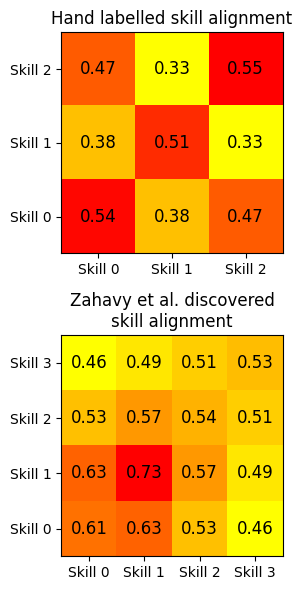

In [20]:
_, axs = plt.subplots(nrows=2, figsize=(3.3, 6))
# ax.set_title("alignment between skill")
axs[0].set_title("Hand labelled skill alignment")
axs[0].imshow(hand_labelled_alignment, cmap='autumn_r', origin="lower")
axs[0].set_yticks(
    np.arange(hand_labelled_plan.unique_skill_types),
    labels=[f"Skill {i}" for i in range(hand_labelled_plan.unique_skill_types)],
)
axs[0].set_xticks(
    np.arange(hand_labelled_plan.unique_skill_types),
    labels=[f"Skill {i}" for i in range(hand_labelled_plan.unique_skill_types)],
)
# for i in range(0, hand_labelled_plan.unique_skill_types - 1):
#     axs[0].axhline(i + 0.5, color="black")
#     axs[0].axvline(i + 0.5, color="black")

for i, j in np.ndindex(hand_labelled_alignment.shape):
    axs[0].text(j, i, f'{hand_labelled_alignment[i, j]:.2f}', ha="center", va="center", color="black", fontsize=12)


axs[1].set_title("Zahavy et al. discovered\nskill alignment")
axs[1].imshow(zahavy_alignment, cmap="autumn_r", origin="lower")
axs[1].set_yticks(
    np.arange(zahavy_plan.unique_skill_types),
    labels=[f"Skill {i}" for i in range(zahavy_plan.unique_skill_types)],
)
axs[1].set_xticks(
    np.arange(zahavy_plan.unique_skill_types),
    labels=[f"Skill {i}" for i in range(zahavy_plan.unique_skill_types)],
)
# for i in range(0, zahavy_plan.unique_skill_types - 1):
#     axs[1].axhline(i + 0.5, color="black")
#     axs[1].axvline(i + 0.5, color="black")

for i, j in np.ndindex(zahavy_alignment.shape):
    axs[1].text(j, i, f'{zahavy_alignment[i, j]:.2f}', ha="center", va="center", color="black", fontsize=12)

plt.tight_layout()
plt.savefig("figs/quantitative/skill-alignment-hand-zahavy-Breakout.pdf")
plt.savefig("figs/quantitative/skill-alignment-hand-zahavy-Breakout.png")